In [5]:
"""
Preamble for most code and jupyter notebooks
@author: tobinsouth
@notebook date: Mar 7, 2023
"""

import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns
import math, string, re, pickle, json, os, sys, datetime, itertools
from collections import Counter
from tqdm import tqdm

In [6]:
# # Read in the head of csv.gz file
# # path = '/data/stays/stays2_14460.csv.gz'
# path = 'data/stays2_14460.csv.gz'

# # Read in the head of csv.gz file
# stays = pd.read_csv(path)

In [7]:
import geopandas as gpd

# Load in zipcode shapefile
zipcodes = gpd.read_file('data/tl_2019_us_zcta510.zip')
# https://www2.census.gov/geo/tiger/TIGER2019/ZCTA5/

In [41]:
ghns = ['geohash9','geohash8','geohash7','geohash6','geohash5','geohash4','geohash3']

# 1. Converting Home Locations to Zip Codes

In [ ]:
users = stays.groupby('user')[['home_lon_med', 'home_lat_med']].median()

In [ ]:
print(users.head())

                                                    home_lon_med  home_lat_med
user                                                                          
0000ff45f7f170db960e4e601167975f7559c5be147d69e...    -71.284748     42.558568
000277100d5593fec35a151e228f6a485210a3fa87cda78...    -71.175020     42.300842
0002a8f1815bcef6bc1613175df0505bd295fb79ed6ace6...    -71.416795     42.111074
00033a3bb5f07e32dc00a69de6c8b4f73d05e5d08d14a8d...    -71.119387     42.419602
000343483445495a56d6d02cd1e1f5cda6e577b636c21c2...    -71.091305     42.360248


In [5]:
from shapely.geometry import Point

# Convert the df DataFrame to a GeoDataFrame
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip(users.home_lon_med, users.home_lat_med)]
geo_users = gpd.GeoDataFrame(users, crs=crs, geometry=geometry)

# Perform spatial join
joined = gpd.sjoin(geo_users, zipcodes, op='within')

# Extract zip codes and merge with original DataFrame
geo_users['zipcode'] = joined['ZCTA5CE10']

/Users/tobin/miniforge3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/tobin/miniforge3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_67799/1414609513.py:9: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4269


In [6]:
# Mapping from users to zipcode
user_to_homezip = geo_users[['zipcode']].to_dict()['zipcode']
# Remove all users with nan for zip codes
user_to_homezip = {k:v for k,v in user_to_homezip.items() if not pd.isna(v)}
len(user_to_homezip)

72941

In [7]:
# Looking at the distribution of zip codes
geo_users['zipcode'].str.slice(0, 3).value_counts().sort_index()

014     1292
017     6500
018    12581
019     7708
020     7068
021    13934
022      256
023     6826
024     6066
025      369
027      517
030     3501
032      181
038     6142
Name: zipcode, dtype: int64

In [8]:
users_traj_lengths = stays.groupby('user').apply(len)
geo_users['length'] = users_traj_lengths

<AxesSubplot: >

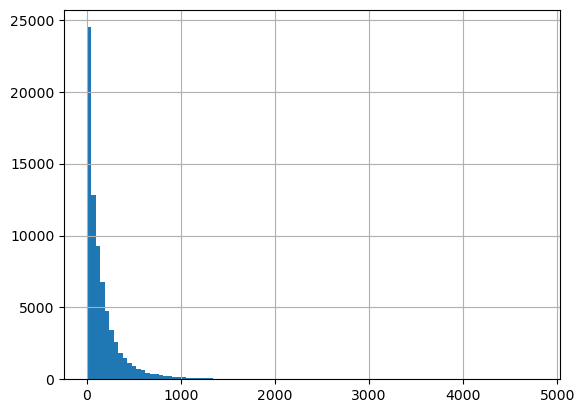

In [19]:
geo_users['length'].hist(bins=100)

user
0000ff45f7f170db960e4e601167975f7559c5be147d69e75460123855ab0eab      1
000277100d5593fec35a151e228f6a485210a3fa87cda78d79c465bbebb6e71e      8
0002a8f1815bcef6bc1613175df0505bd295fb79ed6ace605b933f1a165c718d     38
00033a3bb5f07e32dc00a69de6c8b4f73d05e5d08d14a8d2b6d796a64f3dbb54    176
000343483445495a56d6d02cd1e1f5cda6e577b636c21c2f5922df46c0855919    576
                                                                   ... 
fffbc8a9f385f78cd57b2e21a49d32882d44298254256a77ec6663bad36c3960    119
fffcb2376eb209b7b739b635fcec7e6ffb61615bcb7eed272bbb87674cf3bd2e     14
fffcb34b6656f9884cccdc336a4359e7aeade94dba6c1de6f7b34b7f22484c80     71
fffd27545d8286f0ea39bbae179c6954f1f87a91f108ccd8ebab8e7860a81969     39
fffe58b2fb58c5940b85ba55b07eb4d1d11b36185a4afb2f64a95d49a2025d6f    173
Name: length, Length: 73938, dtype: int64

In [9]:
valid_users = list(geo_users[geo_users['length'] > -1].index) # Keep all for now
len(valid_users)

73938

In [10]:
filtered_stays = stays[stays['user'].isin(valid_users)]

# 2. Converting location traces to geocodes & set intersecting

In [11]:
# Approx 2 min runtime
import pygeohash as pgh
import warnings # Ignore .iloc warnings

def lonlat_to_geohash(lon, lat, r=9):
    """
    Convert longitude and latitude to geohash
    """
    return pgh.encode(lat, lon, r)


warnings.filterwarnings("ignore", message=".*'iloc' is deprecated.*")
filtered_stays['geohash9'] = filtered_stays[['lon_medoid', 'lat_medoid']].apply(lambda x: lonlat_to_geohash(*x, r=9), axis=1)
filtered_stays['geohash8'] = filtered_stays['geohash9'].str.slice(0, 8)
filtered_stays['geohash7'] = filtered_stays['geohash8'].str.slice(0, 7)
filtered_stays['geohash6'] = filtered_stays['geohash7'].str.slice(0, 6)
filtered_stays['geohash5'] = filtered_stays['geohash6'].str.slice(0, 5)
filtered_stays['geohash4'] = filtered_stays['geohash5'].str.slice(0, 4)
filtered_stays['geohash3'] = filtered_stays['geohash4'].str.slice(0, 3)

In [12]:
ghns = ['geohash9','geohash8','geohash7','geohash6','geohash5','geohash4','geohash3']
grouped_sets = filtered_stays.groupby('user').apply(lambda usergroup: {ghn:set(usergroup[ghn].to_list()) for ghn in ghns}).to_dict()

In [29]:
# Calculate the size of the pairwise overlap on a subsample to ablation test
all_zip_codes = set(user_to_homezip.values())

subsampledusers = np.random.choice(list(grouped_sets.keys()), size=1000, replace=False)

rows = []
for user1, user2 in tqdm(itertools.combinations(subsampledusers, 2), total=len(subsampledusers)*(len(subsampledusers)-1)//2, miniters=10**5):
    zip1, zip2 = user_to_homezip.get(user1), user_to_homezip.get(user2)
    if zip1 and zip2:
        overlap = [user1, user2, zip1, zip2] + [len(grouped_sets[user1][ghn] & grouped_sets[user2][ghn]) for ghn in ghns]
        rows.append(overlap)

100%|██████████| 499500/499500 [00:04<00:00, 117570.35it/s]


In [73]:
rows_df = pd.DataFrame(rows, columns=['user1', 'user2', 'zip1', 'zip2'] + ghns)
rows_df['user1_count'] = rows_df['user1'].map(geo_users['length'].to_dict())
rows_df['user2_count'] = rows_df['user2'].map(geo_users['length'].to_dict())

In [72]:
rows_df.to_csv('results/trace_count_filtering_ablation.csv.gz', compression='gzip')

In [92]:
means = rows_df.groupby(['zip1','zip2'])[ghns].mean()
medians = rows_df.groupby(['zip1','zip2'])[ghns].median()
filter_means = rows_df.groupby(['zip1','zip2'])[ghns].mean()[(rows_df.groupby(['zip1','zip2'])[ghns].apply(len) > 10)]
zip_to_zip_overlap_means_df = means.join(medians,rsuffix='median_').join(filter_means, rsuffix='filtered_').reset_index()

# 3. Read back in

In [24]:
zip_to_zip_overlap_means_df = pd.read_csv('results/zip_to_zip_overlap_means_df14460.csv')
zip_to_zip_overlap_means_df['zip1'] = zip_to_zip_overlap_means_df['zip1'].astype(str).str.zfill(5)
zip_to_zip_overlap_means_df['zip2'] = zip_to_zip_overlap_means_df['zip2'].astype(str).str.zfill(5)

# 4. Correlate the FB Social Connectendness Index

In [10]:
!cd data/fb-sci && unzip us-zip-code-us-zip-code-fb-social-connectedness-index-october-2021.zip 

Archive:  us-zip-code-us-zip-code-fb-social-connectedness-index-october-2021.zip
replace zcta_zcta_shard5.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [25]:
all_zips_with_data = set(zip_to_zip_overlap_means_df['zip1']) | set(zip_to_zip_overlap_means_df['zip2'])

In [31]:
social_connectedness = pd.read_csv(file, sep='\t')
social_connectedness['user_loc'] = social_connectedness['user_loc'].astype(str).str.zfill(5)
social_connectedness['fr_loc'] = social_connectedness['fr_loc'].astype(str).str.zfill(5)    

In [35]:
# Loop through the zipfile `us-zip-code-us-zip-code-fb-social-connectedness-index-october-2021.zip` to access each file titled 'zcta_zcta_shardN.tsv`. 
# Each file contains the social connectedness index for zipcodes in the US. Keep only those zipcodes that are in the `all_zips_with_data` set.

# Read in the social connectedness index for each zipcode
all_social_connectedness = []
import glob
for file in tqdm(glob.glob('data/fb-sci/zcta_zcta_shard*.tsv')):
    social_connectedness = pd.read_csv(file, sep='\t')
    social_connectedness['user_loc'] = social_connectedness['user_loc'].astype(str).str.zfill(5)
    social_connectedness['fr_loc'] = social_connectedness['fr_loc'].astype(str).str.zfill(5)    
    social_connectedness = social_connectedness[social_connectedness['user_loc'].isin(all_zips_with_data) & social_connectedness['fr_loc'].isin(all_zips_with_data)]

    all_social_connectedness.append(social_connectedness)
social_connectedness = pd.concat([sc for sc in all_social_connectedness if len(sc) > 0])

100%|██████████| 10/10 [08:23<00:00, 50.38s/it]


In [36]:
len(social_connectedness), len(zip_to_zip_overlap_means_df)

(75625, 39060)

In [ ]:
(55225, 50055)


In [37]:
social_connectedness.rename(columns={'user_loc': 'zip1', 'fr_loc': 'zip2'}, inplace=True)

In [38]:
# Join dataframes
social_connectedness_overlap = social_connectedness.merge(zip_to_zip_overlap_means_df, left_on=['zip1', 'zip2'], right_on=['zip1', 'zip2'], how='left')

In [39]:
social_connectedness_overlap

,zip1,zip2,scaled_sci,geohash9,geohash8,geohash7,geohash6,geohash5,geohash4,geohash3,...,median_geohash5,median_geohash4,median_geohash3,filtered_geohash9,filtered_geohash8,filtered_geohash7,filtered_geohash6,filtered_geohash5,filtered_geohash4,filtered_geohash3
0,01431,01431,85884025,0.000000,0.000000,1.000000,2.000000,3.000000,7.000000,1.000000,...,3.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01431,01432,3756876,0.000000,0.048780,0.445122,0.768293,2.250000,4.585366,1.115854,...,2.0,4.0,1.0,0.000000,0.048780,0.445122,0.768293,2.250000,4.585366,1.115854
2,01431,01434,2819222,0.000000,0.000000,0.100000,0.300000,1.100000,3.900000,1.100000,...,0.0,3.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01431,01450,3947397,0.036232,0.246377,1.065217,1.326087,3.036232,5.391304,1.202899,...,3.0,6.0,1.0,0.036232,0.246377,1.065217,1.326087,3.036232,5.391304,1.202899
4,01431,01460,1957109,0.050000,0.278571,0.864286,1.035714,2.557143,5.164286,1.171429,...,2.0,5.0,1.0,0.050000,0.278571,0.864286,1.035714,2.557143,5.164286,1.171429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75620,03887,03874,1080444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75621,03887,03878,5243645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75622,03887,03884,6601008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75623,03887,03885,1292314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
social_connectedness_overlap['log_sci'] = np.log(social_connectedness_overlap['scaled_sci'])
social_connectedness_overlap = social_connectedness_overlap[social_connectedness_overlap['log_sci'] != 0]

# Log geohashs
for ghn in ghns:
    social_connectedness_overlap['log_'+ghn] = np.log(social_connectedness_overlap[ghn])

/Users/tobin/miniforge3/lib/python3.10/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/537304341.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  social_connectedness_overlap['log_'+ghn] = np.log(social_connectedness_overlap[ghn])


<AxesSubplot: xlabel='log_geohash8', ylabel='log_sci'>

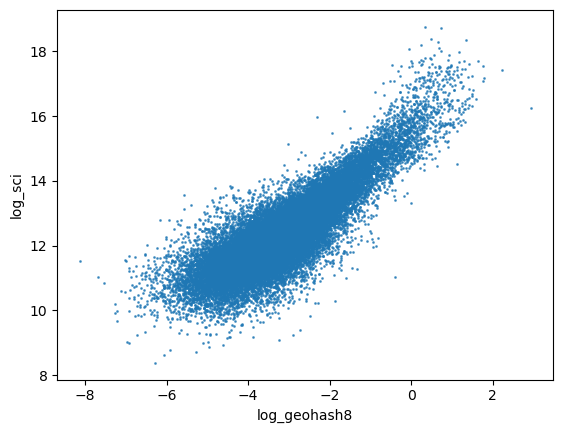

In [54]:
social_connectedness_overlap.plot.scatter('log_geohash8', 'log_sci', alpha=0.7, s=1)

<AxesSubplot: xlabel='log_geohash8', ylabel='log_sci'>

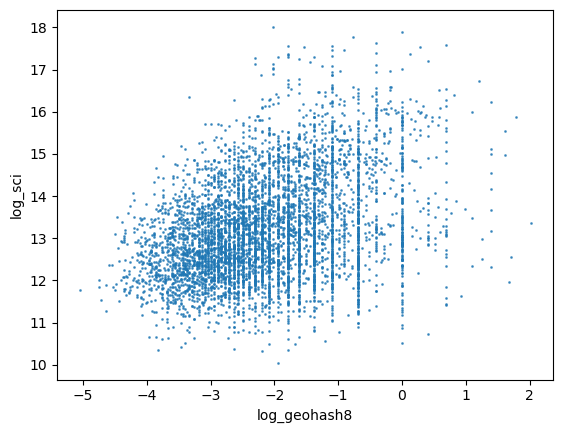

In [114]:
social_connectedness_overlap.plot.scatter('log_geohash8', 'log_sci', alpha=0.7, s=1) # old

/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/2294947663.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.imshow(social_connectedness_overlap.corr('pearson'))


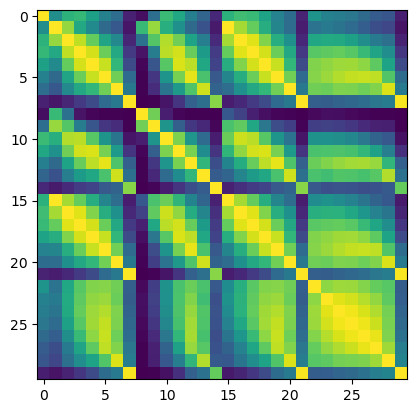

In [55]:
plt.imshow(social_connectedness_overlap.corr('pearson'))

/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_67799/2294947663.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.imshow(social_connectedness_overlap.corr('pearson'))


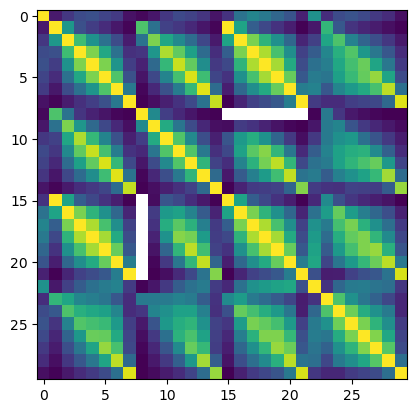

In [115]:
plt.imshow(social_connectedness_overlap.corr('pearson')) # old

In [117]:
social_connectedness_overlap.corr('pearson')]')

SyntaxError: unmatched ']' (1259096394.py, line 1)

In [57]:
social_connectedness_overlap.corr('pearson')['log_sci']

/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/1703301408.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  social_connectedness_overlap.corr('pearson')['log_sci']


scaled_sci           0.514868
geohash9             0.379630
geohash8             0.593011
geohash7             0.740788
geohash6             0.810547
geohash5             0.818006
geohash4             0.784084
geohash3             0.298981
median_geohash9      0.022917
median_geohash8      0.181821
median_geohash7      0.513158
median_geohash6      0.711403
median_geohash5      0.776100
median_geohash4      0.712610
median_geohash3      0.278013
filtered_geohash9    0.483499
filtered_geohash8    0.625861
filtered_geohash7    0.741288
filtered_geohash6    0.811065
filtered_geohash5    0.818341
filtered_geohash4    0.783862
filtered_geohash3    0.299493
log_sci              1.000000
log_geohash9         0.830558
log_geohash8         0.854837
log_geohash7         0.847776
log_geohash6         0.811786
log_geohash5         0.764303
log_geohash4         0.739854
log_geohash3         0.292597
Name: log_sci, dtype: float64

In [110]:
social_connectedness_overlap.corr('pearson')['log_sci']['geohash8'] # old

/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_48314/1703301408.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  social_connectedness_overlap.corr('pearson')['log_sci']


scaled_sci           0.448948
geohash9             0.353709
geohash8             0.557816
geohash7             0.692170
geohash6             0.761388
geohash5             0.769274
geohash4             0.742303
geohash3             0.281734
median_geohash9      0.021287
median_geohash8      0.186240
median_geohash7      0.477070
median_geohash6      0.665515
median_geohash5      0.728500
median_geohash4      0.674585
median_geohash3      0.260551
filtered_geohash9    0.450424
filtered_geohash8    0.583735
filtered_geohash7    0.692508
filtered_geohash6    0.761739
filtered_geohash5    0.769445
filtered_geohash4    0.742070
filtered_geohash3    0.282155
log_sci              1.000000
Name: log_sci, dtype: float64

In [77]:
pearson_log = social_connectedness_overlap.corr('pearson')['log_sci']
pearson_normal = social_connectedness_overlap.corr('pearson')['scaled_sci']
spearman = social_connectedness_overlap.corr('spearman')['log_sci']

spearman_mean = [spearman[ghn] for ghn in sorted(ghns)]
pearson_mean = [pearson_normal[ghn] for ghn in sorted(ghns)]
pearson_mean_log = [pearson_log[ghn] for ghn in sorted(ghns)]
pearson_log_log = [pearson_log[ghn] for ghn in ['log_'+ghn for ghn in sorted(ghns)]]

pearson_filtered = [pearson_normal[ghn] for ghn in ['filtered_'+ghn for ghn in sorted(ghns)]]
pearson_median = [pearson_normal[ghn] for ghn in ['median_'+ghn for ghn in sorted(ghns)]]


/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/2371834653.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_log = social_connectedness_overlap.corr('pearson')['log_sci']
/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/2371834653.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_normal = social_connectedness_overlap.corr('pearson')['scaled_sci']
/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/2371834653.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the 

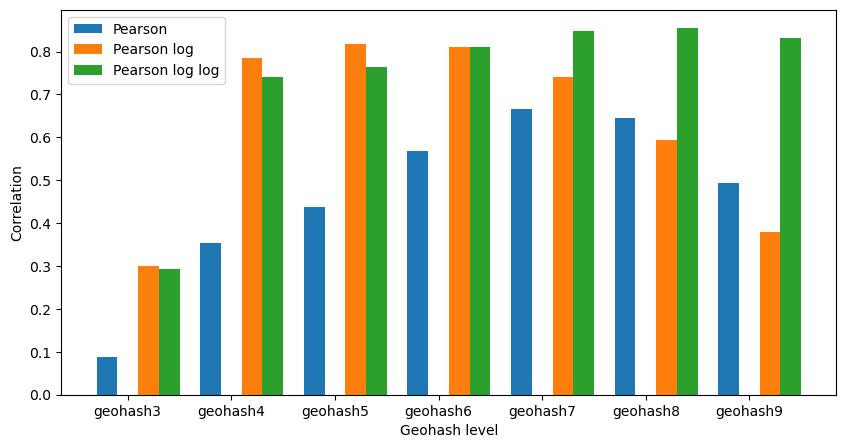

In [59]:
# Plot  correlations as paired vertical bar charts
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(np.arange(len(ghns)), pearson_mean, width=0.2, label='Pearson')
ax.bar(np.arange(len(ghns))+0.4, pearson_mean_log, width=0.2, label='Pearson log')
ax.bar(np.arange(len(ghns))+0.6, pearson_log_log, width=0.2, label='Pearson log log')

# ax.bar(np.arange(len(ghns)), spearman_mean, width=0.2, label='Spearman', alpha = 0.5)
# ax.bar(np.arange(len(ghns))+0.8, pearson_filtered, width=0.2, label='Pearson filtered', alpha = 0.5)
# ax.bar(np.arange(len(ghns))+1.2, pearson_median, width=0.2, label='Pearson median', alpha = 0.5)
ax.set_xticks(np.arange(len(ghns))+0.4/2)
ax.set_xticklabels(sorted(ghns))
ax.set_ylabel('Correlation')
ax.set_xlabel('Geohash level')
ax.legend()
plt.show()

# Next questions:

Baseline for connectedness index? Perhaps interzipcode flows? 

gravity model?

More locations?

What stayz file -> NYC (), LA (), Dallas (), Boston ()




Make a new pretty plot:
- Qualitative network between zips
- Scatter plot w/ & w/o log
- Line plot of correlation vs geohash


# 5. Zip-zip gravity model distances

In [70]:
import math
import pandas as pd

def haversine_distance(lat1, lon1, lat2, lon2):
    """ Calculate the great circle distance between two points. More accurate than euclidean distance for Earth locations."""
    R = 6371  # Earth's radius in kilometers
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def load_zipcode_coordinates(url):
    df = pd.read_csv(url)
    df['ZIP'] = df['ZIP'].astype(str).str.zfill(5)
    return {row.ZIP: (row.LAT, row.LNG) for _, row in df.iterrows()}

url = "https://gist.githubusercontent.com/erichurst/7882666/raw/5bdc46db47d9515269ab12ed6fb2850377fd869e/US%2520Zip%2520Codes%2520from%25202013%2520Government%2520Data"
zipcode_coordinates = load_zipcode_coordinates(url)


# Calculate distances
zip_to_zip_distance = []
for zip1, zip2 in tqdm(social_connectedness[['zip1','zip2']].itertuples(index=False)):
    if zip1 is not np.nan and zip2 is not np.nan:
        distance = haversine_distance(zipcode_coordinates[zip1][0], zipcode_coordinates[zip1][1], zipcode_coordinates[zip2][0], zipcode_coordinates[zip2][1])
        zip_to_zip_distance.append([zip1, zip2, distance])

75405it [00:00, 607599.80it/s]


In [71]:
# Join on dataframes
zip_to_zip_distance_df = pd.DataFrame(zip_to_zip_distance, columns=['zip1', 'zip2', 'distance'])
zip_to_zip_distance_df['gravity'] = zip_to_zip_distance_df['distance']**(-2)
zip_to_zip_distance_df['gravity1.5'] = zip_to_zip_distance_df['distance']**(-1.5)
social_connectedness_distance = social_connectedness_overlap.merge(zip_to_zip_distance_df, left_on=['zip1', 'zip2'], right_on=['zip1', 'zip2'], how='left')

In [72]:
social_connectedness_distance['log_sci'] = np.log(social_connectedness_distance['scaled_sci'])
social_connectedness_distance.corr('pearson')[['log_sci', 'scaled_sci']]

/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/1169299226.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  social_connectedness_distance.corr('pearson')[['log_sci', 'scaled_sci']]


,log_sci,scaled_sci
scaled_sci,0.514868,1.000000
geohash9,0.379630,0.492533
geohash8,0.593011,0.645782
geohash7,0.740788,0.665856
geohash6,0.810547,0.568424
geohash5,0.818006,0.436917
geohash4,0.784084,0.353517
geohash3,0.298981,0.089050
median_geohash9,0.022917,0.032267
median_geohash8,0.181821,0.357079


In [75]:
# Baseline lines
pearson_gravity = social_connectedness_distance.corr('pearson')['gravity']['scaled_sci']
pearson_gravity15 = social_connectedness_distance.corr('pearson')['gravity1.5']['scaled_sci']
spearman_gravity = social_connectedness_distance.corr('spearman')['gravity']['scaled_sci']

/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/2146858808.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_gravity = social_connectedness_distance.corr('pearson')['gravity']['scaled_sci']
/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/2146858808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  pearson_gravity15 = social_connectedness_distance.corr('pearson')['gravity1.5']['scaled_sci']
/var/folders/b3/n7scs1h12mj_yk8mc2rpxkmm0000gn/T/ipykernel_76688/2146858808.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Sele

In [80]:
social_connectedness_distance.to_csv('results/all_PSI_SCI_gravity.csv.gz', compression='gzip', index=False)

# Making Final Plots

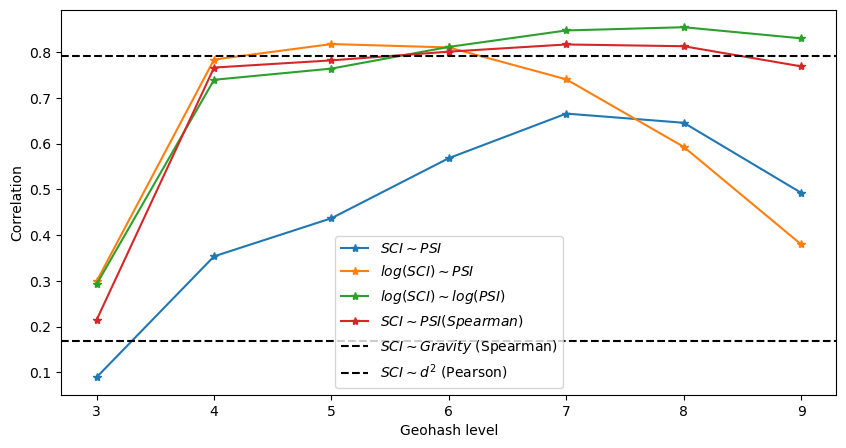

In [78]:
# def PSI_SCI_lineplot(ax):
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(len(ghns)), pearson_mean, '*-', label='$SCI \sim PSI$')
ax.plot(np.arange(len(ghns)), pearson_mean_log, '*-', label='$log(SCI) \sim PSI$')
ax.plot(np.arange(len(ghns)), pearson_log_log, '*-', label='$log(SCI) \sim log(PSI)$')

# ax.plot(np.arange(len(ghns)), pearson_filtered, '*-', label='$SCI \sim PSI filtered$')
# ax.plot(np.arange(len(ghns)), pearson_median, '*-', label='$SCI \sim PSI median$')
ax.plot(np.arange(len(ghns)), spearman_mean, '*-', label='$SCI \sim PSI (Spearman)$')

ax.axhline(spearman_gravity, color='black', linestyle='--', label='$SCI \sim Gravity$ (Spearman)')
ax.axhline(pearson_gravity, color='black', linestyle='--', label='$SCI \sim d^2$ (Pearson)')
# ax.axhline(pearson_gravity15, color='black', linestyle=':', label='$SCI \sim Gravity$ (Pearson)')



ax.set_xticks(np.arange(len(ghns)))
ax.set_xticklabels(list(range(3, 10)))
ax.set_ylabel('Correlation')
ax.set_xlabel('Geohash level')
ax.legend()
plt.show()

# Ablation testing on filtering

In [ ]:
valid_users = list(geo_users[geo_users['length'] > -1].index) # Keep all for now
filtered_stays = stays[stays['user'].isin(valid_users)]

In [ ]:
# Approx 2 min runtime
import pygeohash as pgh
import warnings # Ignore .iloc warnings

warnings.filterwarnings("ignore", message=".*'iloc' is deprecated.*")
warnings.filterwarnings("ignore", category=FutureWarning)

filtered_stays['geohash9'] = filtered_stays[['lon_medoid', 'lat_medoid']].apply(lambda x: pgh.encode(*x, 9), axis=1)
filtered_stays['geohash8'] = filtered_stays['geohash9'].str.slice(0, 8)
filtered_stays['geohash7'] = filtered_stays['geohash8'].str.slice(0, 7)
filtered_stays['geohash6'] = filtered_stays['geohash7'].str.slice(0, 6)
filtered_stays['geohash5'] = filtered_stays['geohash6'].str.slice(0, 5)
filtered_stays['geohash4'] = filtered_stays['geohash5'].str.slice(0, 4)
filtered_stays['geohash3'] = filtered_stays['geohash4'].str.slice(0, 3)

ghns = ['geohash9','geohash8','geohash7','geohash6','geohash5','geohash4','geohash3']
grouped_sets = filtered_stays.groupby('user').apply(lambda usergroup: {ghn:set(usergroup[ghn].to_list()) for ghn in ghns}).to_dict()

In [132]:
# Calculate the size of the pairwise overlap on a subsample to ablation test
all_zip_codes = set(user_to_homezip.values())

subsampledusers = np.random.choice(list(grouped_sets.keys()), size=10000, replace=False)

rows = []
for user1, user2 in tqdm(itertools.combinations(subsampledusers, 2), total=len(subsampledusers)*(len(subsampledusers)-1)//2, miniters=10**5):
    zip1, zip2 = user_to_homezip.get(user1), user_to_homezip.get(user2)
    if zip1 and zip2:
        overlap = [user1, user2, zip1, zip2] + [len(grouped_sets[user1][ghn] & grouped_sets[user2][ghn]) for ghn in ghns]
        rows.append(overlap)

100%|██████████| 49995000/49995000 [05:56<00:00, 140198.97it/s]


In [133]:
rows_df = pd.DataFrame(rows, columns=['user1', 'user2', 'zip1', 'zip2'] + ghns)
rows_df['user1_count'] = rows_df['user1'].map(geo_users['length'].to_dict())
rows_df['user2_count'] = rows_df['user2'].map(geo_users['length'].to_dict())

In [135]:
means = rows_df.groupby(['zip1','zip2'])[ghns].mean()
medians = rows_df.groupby(['zip1','zip2'])[ghns].median()
filter_means = rows_df.groupby(['zip1','zip2'])[ghns].mean()[(rows_df.groupby(['zip1','zip2'])[ghns].apply(len) > 10)]
zip_to_zip_overlap_means_df = means.join(medians,rsuffix='median_').join(filter_means, rsuffix='filtered_').reset_index()

In [136]:
all_zips_with_data = set(zip_to_zip_overlap_means_df['zip1']) | set(zip_to_zip_overlap_means_df['zip2'])

In [137]:
# Read in the social connectedness index for each zipcode
all_social_connectedness = []
import glob
for file in tqdm(glob.glob('data/fb-sci/zcta_zcta_shard*.tsv')):
    social_connectedness = pd.read_csv(file, sep='\t')
    social_connectedness['user_loc'] = social_connectedness['user_loc'].astype(str).str.zfill(5)
    social_connectedness['fr_loc'] = social_connectedness['fr_loc'].astype(str).str.zfill(5)    
    social_connectedness = social_connectedness[social_connectedness['user_loc'].isin(all_zips_with_data) & social_connectedness['fr_loc'].isin(all_zips_with_data)]

    all_social_connectedness.append(social_connectedness)
social_connectedness = pd.concat([sc for sc in all_social_connectedness if len(sc) > 0])

social_connectedness.rename(columns={'user_loc': 'zip1', 'fr_loc': 'zip2'}, inplace=True)

social_connectedness['log_sci'] = np.log(social_connectedness['scaled_sci'])

print(len(social_connectedness), len(zip_to_zip_overlap_means_df))

100%|██████████| 10/10 [08:50<00:00, 53.07s/it]

75625 77074


In [139]:
# Loop through varying filtering levels and reclaculate the correlation

pearson_corr_ablation, spearman_corr_ablation = [], []
for filterN in tqdm([0]+list(range(0,100,5))):
  filtered_rows_df = rows_df[(rows_df['user1_count'] > filterN) & (rows_df['user2_count'] > filterN)]

  means = filtered_rows_df.groupby(['zip1','zip2'])[ghns].mean()
  medians = filtered_rows_df.groupby(['zip1','zip2'])[ghns].median()
  filter_means = filtered_rows_df.groupby(['zip1','zip2'])[ghns].mean()[(filtered_rows_df.groupby(['zip1','zip2'])[ghns].apply(len) > 10)]
  zip_to_zip_overlap_means_df = means.join(medians,rsuffix='median_').join(filter_means, rsuffix='filtered_').reset_index()

  # Join dataframes
  social_connectedness_overlap = social_connectedness.merge(zip_to_zip_overlap_means_df, left_on=['zip1', 'zip2'], right_on=['zip1', 'zip2'], how='left')

  # Log geohashs
  for ghn in ghns: social_connectedness_overlap['log_'+ghn] = np.log1p(social_connectedness_overlap[ghn])

  # Calculate correlation
  pearson_corr_ablation.append(social_connectedness_overlap.corr('pearson'))
  spearman_corr_ablation.append(social_connectedness_overlap.corr('spearman'))

100%|██████████| 20/20 [08:09<00:00, 24.46s/it]


[Text(-2.5, 0, '0'),
 Text(0.0, 0, '10'),
 Text(2.5, 0, '20'),
 Text(5.0, 0, '30'),
 Text(7.5, 0, '40'),
 Text(10.0, 0, '50'),
 Text(12.5, 0, '60'),
 Text(15.0, 0, '70'),
 Text(17.5, 0, '80'),
 Text(20.0, 0, '90')]

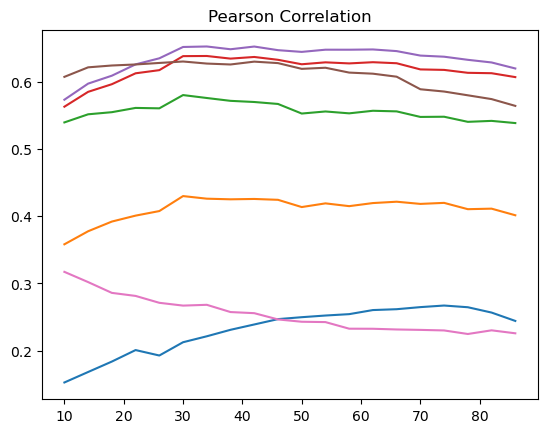

In [159]:
ax = pd.concat([corr['log_sci'][ghns] for corr in pearson_corr_ablation], axis=1).T.plot(legend=False, title='Pearson Correlation')
ax.set_xticklabels(range(0,100,10))

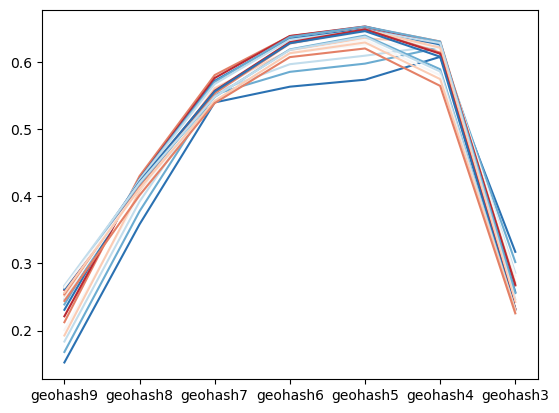

In [163]:
import seaborn as sns
sns.set_palette(sns.color_palette("RdBu_r", 7))
for filter, corr in zip(range(0,100,5), pearson_corr_ablation):
    plt.plot(corr['log_sci'][ghns], label=filter)
    